In [1]:
import numpy as np
import math
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
import classical_newsvendor_utils

from os import listdir
from os.path import isfile, join

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

import joblib

In [2]:
scaler = joblib.load('scaler.gz')

tmean = torch.tensor(scaler.mean_.item())
tstd = torch.tensor(scaler.scale_.item())

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [60]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [61]:
noise_type = 'multimodal'

In [62]:
N_test = 3000

X, y = data_generator.data_1to1(N_test, noise_level=1, noise_type=noise_type)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [63]:
models_path = './models/'
csvs_path = './newsvendor_results/'
csv_names = [f for f in listdir(csvs_path) if (isfile(join(csvs_path, f)) and noise_type in f)]

In [64]:
df_results = pd.DataFrame()

for cn in csv_names:
    csv_name = cn
    model_name = cn.replace('csv','pkl')

    df_aux = pd.read_csv(csvs_path+csv_name)
    df_aux = df_aux.set_index('Unnamed: 0')
    df_aux.columns = [csv_name]
    
    df_results = pd.concat([df_results, df_aux], axis=1)

In [65]:
df_results.loc[0.1]

mse_nv1_01_multimodal_nr.csv             1.708
ann0_multimodal_nr.csv                   1.705
elbo2_nv1_10_50_multimodal_nr.csv     -175.855
mse_nv1_100_multimodal_nr.csv            1.131
elbo2_nv1_10_40_multimodal_nr.csv     -162.986
elbo2_nv1_3000_40_multimodal_nr.csv      0.748
elbo2_nv1_00_10_multimodal_nr.csv     -121.172
bnnbnn_multimodal_nr.csv                 1.461
elbo_nv1_500_20_multimodal_nr.csv        1.448
elbo_nv1_10_20_multimodal_nr.csv         1.612
elbo2_nv1_1000_10_multimodal_nr.csv      0.680
elbo2_nv1_10_10_multimodal_nr.csv      -77.713
elbo2_nv1_02_20_multimodal_nr.csv     -180.232
elbo_nv1_100_20_multimodal_nr.csv        1.562
elbo2_nv1_1000_50_multimodal_nr.csv   -162.590
elbo2_nv1_500_40_multimodal_nr.csv       0.910
flowflow_multimodal_nr.csv               0.539
elbo2_nv1_00_00_multimodal_nr.csv      -79.665
elbo_nv1_3000_20_multimodal_nr.csv       1.213
elbo2_nv1_01_00_multimodal_nr.csv      -81.534
bnn0.2_multimodal_nr.csv                 0.723
mse_nv1_50_mu

In [66]:
result_file_mse = model_name_mse.replace('.pkl','_nr.csv')
result_file_bnn_bayes = model_name_bnn_bayes.replace('.pkl','_nr.csv')
result_file_flow = model_name_flow.replace('.pkl','_nr.csv')

In [67]:
model_name_mse = "ann0_multimodal.pkl"
model_name_bnn_bayes = "bnn0.2_multimodal.pkl"
model_name_flow = "flow_multimodal.pkl"

In [68]:
model_mse = torch.load(f'./models/{model_name_mse}')
model_bnn_bayes = torch.load(f'./models/{model_name_bnn_bayes}')
model_flow = torch.load(f'./models/{model_name_flow}')

In [69]:
#model_mse.update_n_samples(1000)
model_bnn_bayes.update_n_samples(1000)
model_bnn_bayes.update_n_samples(200)

In [70]:
xt = torch.tensor(np.arange(-2.0, 2.0, 1/1000), dtype = torch.float32)

In [71]:
y_pred_bayes = model_bnn_bayes.forward_dist(xt.unsqueeze(1))

In [72]:
M = 1000
N = xt.shape[0]

y_pred_flow = torch.zeros((M, N))

for i in range(0, N):
    y_pred_flow[:,i] = model_flow.condition(xt.unsqueeze(1)[i]).sample(torch.Size([M,])).squeeze()

In [73]:
y_pred_ann = model_mse(xt.unsqueeze(1))

In [74]:
def inverse_transform(y):
    return y*tstd + tmean
y_pred_ann_orig = inverse_transform(y_pred_ann)
y_pred_bayes_orig = inverse_transform(y_pred_bayes)
y_pred_flow_orig = inverse_transform(y_pred_flow)
#y_orig = inverse_transform(y)

In [83]:
def plot_regression(X, y, xt, y_pred, method, color_pred, noise_type):

    y_pred_np = y_pred.squeeze().detach().numpy()
    y_np = y.detach().numpy()
    
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    
    if method in ['BNN', 'FLOW']:        
        for i in range(0, len(y_pred_np)):
            ax.scatter(xt.detach(), y_pred_np[i],
                        color=color_pred, alpha=0.01, s=0.05)
        ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.2)
        
    elif method in ['ANN']:
        ax.scatter(X[:,0].detach(), y_np, color='#004488', label='Groundtruth', s=8, alpha=0.5)
        ax.scatter(xt.unsqueeze(1).detach().numpy(), 
                        y_pred_np, 
                        color=color_pred, 
                        alpha=0.8, 
                        s=3)
         
    else:
        print('Not a valid method')
        exit()
        
    
    ax.set_xlabel('Input')
    ax.set_ylabel('Output (Demand)')

    legend_elements = [Line2D([0], [0], color=color_pred, lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Groundtruth',
                          markerfacecolor='#004488', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{method}_{noise_type}.png')

In [84]:
'#EE3377', '#CC3311', '#EE7733'

('#EE3377', '#CC3311', '#EE7733')

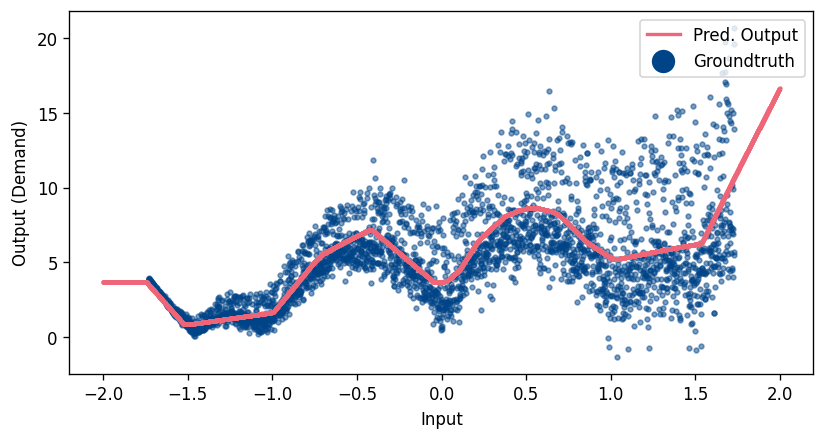

In [85]:
plot_regression(X, y, xt, y_pred_ann_orig, 'ANN', '#EE6677', noise_type)

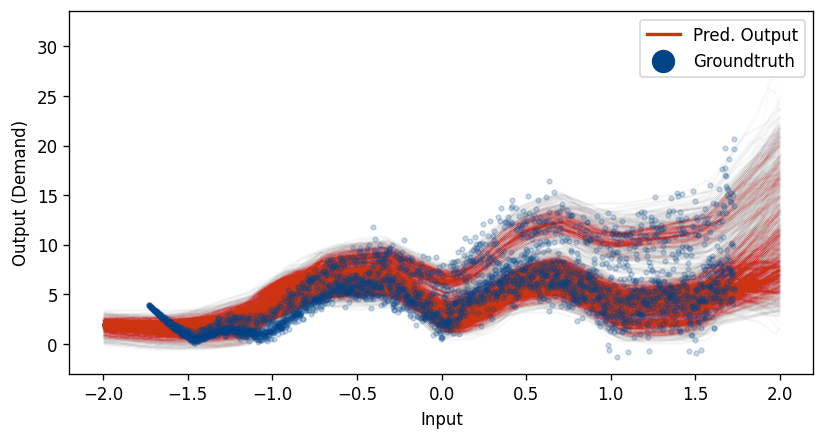

In [86]:
plot_regression(X, y, xt, y_pred_bayes_orig, 'BNN', '#CC3311', noise_type)

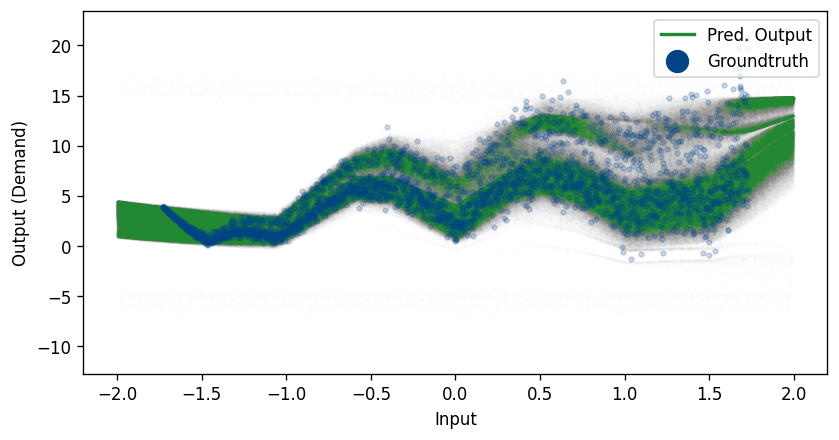

In [87]:
plot_regression(X, y, xt, y_pred_flow_orig, 'FLOW', '#228833', noise_type)

In [ ]:
result_file_mse
result_file_bnn_bayes
result_file_flow

In [56]:
df_results[result_file_mse].keys().tolist()

[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [ ]:
'#EE3377', '#CC3311', '#EE7733'

def compute_nv_curve(X, y, model, M=1000):
    sell_price = 200
    dict_results_nr = {}
    for cost_price in (np.arange(0.1,0.9,0.03)*sell_price):
        quantile = (sell_price-cost_price)/sell_price
        dict_results_nr[quantile] = round(
            classical_newsvendor_utils.compute_norm_regret(
            X, y, model, M, sell_price, cost_price).item(), 
            3)
    return dict_results_nr

nr_ann = compute_nv_curve(X, y, model_mse, M=1000)
nr_ann_noise = compute_nv_curve(X, y, model_mse_noise, M=1000)
nr_bnn = compute_nv_curve(X, y, model_bnn_bayes, M=1000)

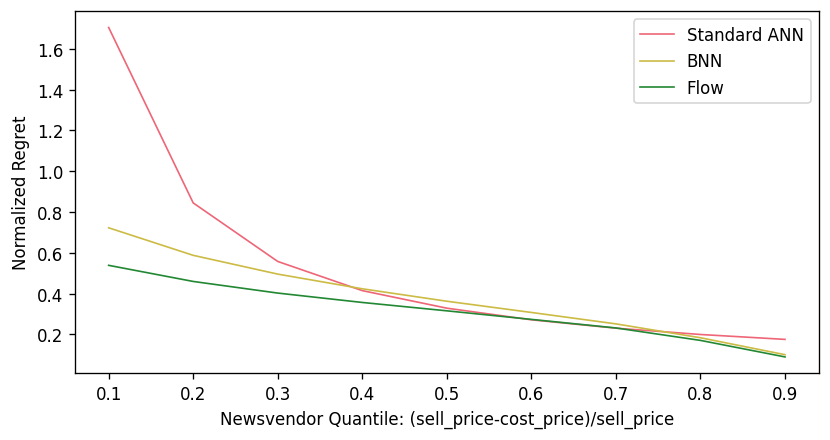

In [82]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(df_results[result_file_mse].keys().tolist(), 
        df_results[result_file_mse].values.tolist(), 
        color='#EE6677', label='Standard ANN', linewidth=1)

ax.plot(df_results[result_file_bnn_bayes].keys().tolist(), 
        df_results[result_file_bnn_bayes].values.tolist(), 
        color='#CCBB44', label='BNN', linewidth=1)

ax.plot(df_results[result_file_flow].keys().tolist(), 
        df_results[result_file_flow].values.tolist(),
        color='#228833', label='Flow', linewidth=1)

ax.legend()

ax.set_ylabel('Normalized Regret')
ax.set_xlabel('Newsvendor Quantile: (sell_price-cost_price)/sell_price')
fig.savefig('./figures/newsvendor_quantile_curve.png')